Clipping DEM/ICESat-2 data using polygons (GLIMS data)

In [1]:
# !pip install -e Assimilation

%load_ext autoreload
%autoreload 2

1. Reading DEM and ICESat-2 data



In [2]:
from simlib.coregistration import reference_dem
from simlib import atl06lib
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd

%matplotlib inline

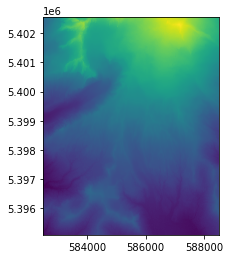

In [3]:
dem_path = '/srv/shared/data-knuth/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.show()

In [4]:
is2_paths = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# is2_paths = glob.glob('/srv/shared/data-whyjay/ICESat-2_Baker_Processed/*.h5')

# Variables we want to plot
vnames = ['x', 'y', 'h_li']
# import h5py
# with h5py.File(is2_paths[0], 'r') as f:
#     vnames = [key for key in f.keys()]
# List with one dataframe per file
is2_dds = [dd.from_array(atl06lib.read_h5(f), columns=vnames) for f in is2_paths]
is2_dd = dd.concat(is2_dds)
is2_ddf = is2_dd.compute()
is2_gpd = gpd.GeoDataFrame(is2_ddf, geometry=gpd.points_from_xy(is2_dd['x'], is2_dd['y']), crs='EPSG:' + dem.epsg)

print('Number of points:', len(is2_gpd))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')


AttributeError: 'tuple' object has no attribute 'ndim'

2. Reading GLIMS data at baker

(5395092.518148141, 5402543.276693823)

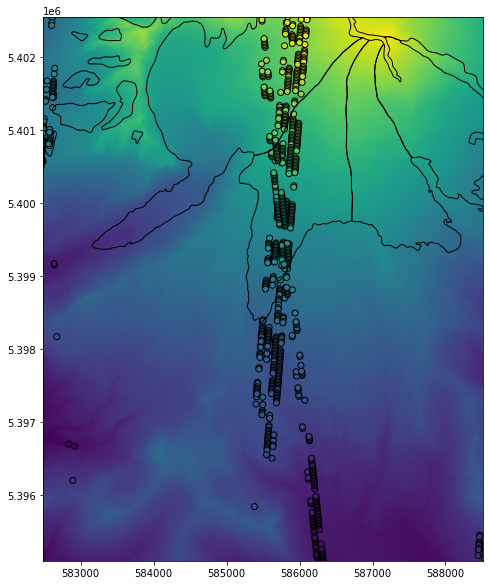

In [80]:
# !ogr2ogr -t_srs EPSG:32610 glims_polygons_EPSG32610.shp glims_polygons.shp

glims_path = '/srv/shared/data-whyjay/glims_mtBaker/glims_polygons_EPSG32610.shp'
shapefile = gpd.read_file(glims_path)

# shapefile['geometry'] = shapefile['geometry'].to_crs(epsg=int(dem.epsg))

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd.plot(ax=ax, column='h_li', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])


3. Apply the points-in-polygon algorithm and add a column "on_ice" (value = 1 or 0) to IS2 gpd array

In [62]:
is2_gpd[['x', 'y']].to_numpy()

# atl06lib.points_in_polygon()

array([[ 585820.03377985, 5402470.98725092],
       [ 585818.4821596 , 5402451.0188871 ],
       [ 585812.35473851, 5402371.14260766],
       ...,
       [ 588454.68198173, 5395265.20515378],
       [ 588453.10735559, 5395245.23842614],
       [ 588446.64963034, 5395165.38284914]])

In [92]:
idx = atl06lib.points_in_polygon(is2_gpd[['x', 'y']].to_numpy(), glims_path)
is2_gpd['on_ice'] = idx


In [1]:
# is2_gpd[is2_gpd['on_ice'] == True]

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
is2_gpd[is2_gpd['on_ice'] == True].plot(ax=ax, column='h_li', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])

NameError: name 'plt' is not defined

In [ ]:
dem.create_bare_rock_mask(method='RGI', polygon_shapefile=glims_path)